In [2]:
import os
import cv2
import json
import importlib
import numpy as np
from PIL import Image
from IPython.display import display
import utils.process_utils as process_utils
importlib.reload(process_utils)

<module 'utils.dataset_process' from '/home/shitianhao/project/DatProc/utils/dataset_process.py'>

In [3]:
# open json file
json_path = '/datar/DAD-3DHeads/val/meta_1-1.json'

image_folder_dir = os.path.dirname(json_path)

with open(json_path) as json_file:
    data = json.load(json_file)


In [ ]:
vis_sample = 20

for img_path, meta in data.items():
    # load image
    abs_img_path = os.path.join(image_folder_dir, img_path)
    for box_id, box_meta in meta.items():
        lm = box_meta['landmarks']
        box = box_meta['head_box']
        if lm is None: continue
        img = cv2.imread(abs_img_path)
        box_x, box_y, box_w, box_h = box
        box_img = img[box_y:box_y+box_h, box_x:box_x+box_w].copy()
        vis_scale = 512/box_h
        for pt in lm:
            pt = (int(pt[0]), int(pt[1]))
            cv2.circle(box_img, pt, int(4/vis_scale), [0, 255, 0], -1)
        box_img_ = cv2.cvtColor(box_img, cv2.COLOR_BGR2RGB)
        box_img_ = cv2.resize(box_img_, (512, 512))
        display(Image.fromarray(box_img_))
        vis_sample -= 1
    if vis_sample == 0: break


# K-Hairstyle Face Mask Visualization

In [ ]:
import cv2
import numpy as np
import PIL.Image as Image
from IPython.display import display
from utils.khs_filter import process_json
khs_sample_json_path = './assets/MN322068_040.json'
image_path = './assets/MN322068-040.jpg'
polygon = process_json(khs_sample_json_path)

image = np.array(Image.open(image_path))
h, w = image.shape[:2]
scale = 512/h
coords_list = []
for pt in polygon:
    pt_coord = [int(pt['x']), int(pt['y'])]
    # cv2.circle(image, pt_coord, int(2/scale), [0, 255, 0], -1)
    coords_list.append(pt_coord)
coords = np.array(coords_list).reshape((-1, 1, 2))
image = cv2.fillPoly(image, [coords], color=[0, 255, 0])
# image = cv2.resize(image, (0,0), fx=scale, fy=scale)
display(Image.fromarray(image))

# FFHQ Landmark Visualization

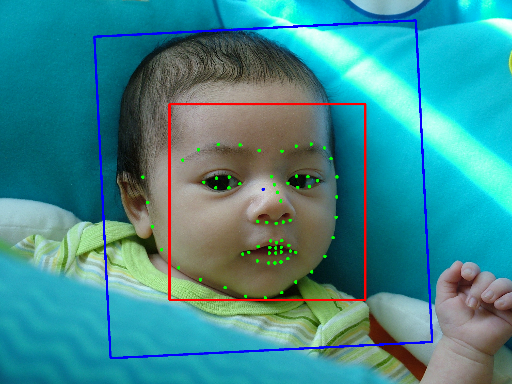

In [21]:
import os
import cv2
import json
import numpy as np
from PIL import Image
from IPython.display import display

ffhq_lm_path = 'assets/ffhq-sample.json'
ffhq_datset_path = '/datar/FFHQ/'
with open(ffhq_lm_path, 'r') as json_file:
    data = json.load(json_file)
itw_img_path = data["0"]["in_the_wild"]["file_path"]
itw_img_path = os.path.join(ffhq_datset_path, itw_img_path)
max_side = 512
image = Image.open(itw_img_path)
lm = data["0"]["in_the_wild"]["face_landmarks"]
rect = data["0"]["in_the_wild"]["face_rect"]
quad = data["0"]["in_the_wild"]["face_quad"]
quad = np.array(quad, np.int32).reshape((-1, 1, 2))
quad_center = np.mean(quad[:, 0, :], axis=0).astype(np.int32)
x_1, y_1, x_2, y_2= rect
image = np.array(image)
for pt in lm:
    pt_int = (int(pt[0]), int(pt[1]))
    image = cv2.circle(image, pt_int, int(2/scale), [0, 255, 0], -1)
image = cv2.circle(image, quad_center, int(2/scale), [0, 0, 255], -1)
cv2.rectangle(image, (x_1, y_1), (x_2, y_2), [255, 0, 0], int(2/scale)) # not sure if this is the correct box
image = cv2.polylines(image, [quad], isClosed=True, color=[0, 0, 255], thickness=int(2/scale))
scale = 512 / np.max(image.shape[:2])
image = cv2.resize(image, (0,0), fx=scale, fy=scale)
display(Image.fromarray(image))



Conclusion: the json of FFHQ follows the following convention:
```json
{
    "data_index":{
        "category": "Training/Validating...",
        "metadata": {...},
        "image" : {
            // image attributes. the attributes for image, thumbnail and in-the-wild is same
        },
        "thumbnail":{},
        "in-the-wild":{
            "file_path": "relative path with the current json", // note that the 00000 in between the path should be deleted,
            "pixel_size":[
                1000,
                2000
            ], // image size
            "face_landmarks":[
                ["x1", "y1"],
                ["x2", "y2"],
                ......
                ["x68", "y68"]
            ], //facial landmark
        }
    }
}
```

# LPFF Landmark Visualization

# Renaming the meta files of WEB Dataset
The following cell is a one-off script that modifies meta files of WEB dataset.
It changes the paths in these files from absolute path to relative path.

In [3]:
import os
import json
from tqdm import tqdm
from utils.process_utils import find_meta_files

WEB_DATASET_PATH = '/datar/Web/'

meta_file_paths = find_meta_files(WEB_DATASET_PATH)
renamed_attrs = ["head_image_path" ,"head_parsing_path" ,"align_image_path" ,"align_parsing_path"]

for meta_file_path in tqdm(meta_file_paths, position=0, leave=True):
    with open(meta_file_path, 'r') as json_file:
        data = json.load(json_file)
    for img_rel_path in tqdm(data.keys(), position=1, leave=False):
        for box in data[img_rel_path]["head"].keys():
            if data[img_rel_path]["raw"]["q2b_tf"][box] is None: continue
            for attr in renamed_attrs:
                data[img_rel_path]["head"][box][attr] = data[img_rel_path]["head"][box][attr].replace('/datar/Web/', '')
    with open(meta_file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)


100%|██████████| 3/3 [00:33<00:00, 11.33s/it]
